# CharacterTrajectories Forecasting Visualizations

## Overview

This notebook contains the code for visualizing the trajectories forecasted by the sequential models based on 70% sequence data from the CharacterTrajectories dataset.

In [28]:
import sys
import os

# Get the current working directory
_here = os.path.abspath(os.path.dirname(''))

# Append the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(_here, '../../')))

import torch
import torch.nn as nn
import torchcde
import numpy as np
from src.models.TransformerSeq import Transformer
from src.models.NeuralCDETransformer import NeuralCDETransformer
from src.models.NeuralCDEODE import NeuralCDEODE
from src.models.NeuralCDELSTM import NeuralCDELSTM
from src.models.LSTMEncoderDecoder import LSTMEncoderDecoder
from src.data.transforms import preprocess_for_transformer, fill_forward

# Set up matplotlib
import matplotlib.pyplot as plt

In [29]:
datapath = '../../data/processed/CharacterTrajectories/regression/30'

X = torch.load(f'{datapath}/X_test.pt')
y = torch.load(f'{datapath}/y_test.pt')

In [38]:
def strip_time(x):
    # Strip time channel
    x = x[:, :, 1:]

    # Get mask of y (where all values are zero)
    mask = x == 0
    mask = ~mask

    return x, mask

def getLenghts(inputs):
    # inputs is a tensor of size (batch, sequence_length, input_channels)
    # returns a list of size batch, indicating the true sequence length of each batch
    lengths = []
    for i in range(inputs.shape[0]):
        for j in range(1,inputs.shape[1]+1):
            if j == inputs.shape[1] or inputs[i][j][0] == 0:
                lengths.append(j)
                break

    return torch.tensor(lengths, dtype=torch.long).cpu()

def plot_trajectory(x_batch, pred_y, id):
    pred_y = pred_y.detach().numpy()
    x_batch = x_batch.detach().numpy()

    pred_y = pred_y[id]
    x_batch = x_batch[id]

    x_batch = x_batch[:, 1:]

    pred_y = np.concatenate([x_batch, pred_y], axis=0)

    # Plot predicted trajectory and ground truth trajectory
    pred_vx, pred_vy, pred_f = [pred_y[: , i] for i in range(pred_y.shape[1])]

    # Integrate velocities to get positions
    pred_x, pred_y = np.cumsum(pred_vx), np.cumsum(pred_vy)

    # Remove last element and insert 0 to the beginning
    pred_x, pred_y = np.insert(pred_x[:-1], 0, 0), np.insert(pred_y[:-1], 0, 0)

    # Handle NaN values by only considering non-NaN values for normalization
    min_value, max_value = np.nanmin(pred_f), np.nanmax(pred_f)
    pred_f_normal = (pred_f - min_value) / (max_value - min_value)

    # Determine index for splitting the line into two segments
    split_index = int(0.7 * len(pred_x))

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(pred_x[:split_index], pred_y[:split_index], label='Initial (blue)', color='blue')
    plt.plot(pred_x[split_index:], pred_y[split_index:], label='Forecast (red)', color='red')
    plt.scatter(pred_x, pred_y, c=pred_f_normal, cmap='viridis', label='Predicted force')
    plt.colorbar()
    plt.legend()
    plt.title('Forecasting of CharacterTrajectories')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

## Ground Truth

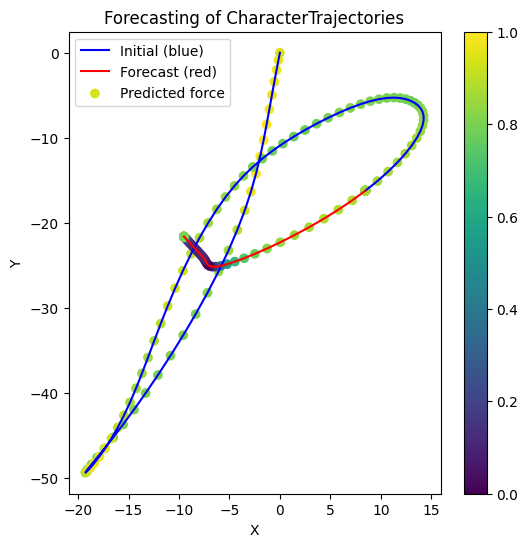

In [42]:
# Define hyperparameters
HP = {
    'log_dir': '/logs',
    'data_path': '../../data/processed/CharacterTrajectories/regression/30',
    'epochs': 150,
    'lr': 1e-3,
    'batch_size': 32,
    'input_channels': 4,
    'hidden_channels': 32,
    'output_channels': 3,
    'hidden_layers': 3,
    'n_heads': 4,
    'n_layers': 3,
    'dropout': 0.1
}

X_test = X
X_test = X_test.float()
y_test = y
y_test = y_test.float()

# Set up test dataloader
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=HP['batch_size'])

batch_x, batch_y = next(iter(test_dataloader))

# Get mask of batch_y (where all values are zero)
batch_y, mask = strip_time(batch_y)

plot_trajectory(batch_x, batch_y, 25)

## Transformer Encoder-Decoder Model

The model has 838,243 trainable parameters


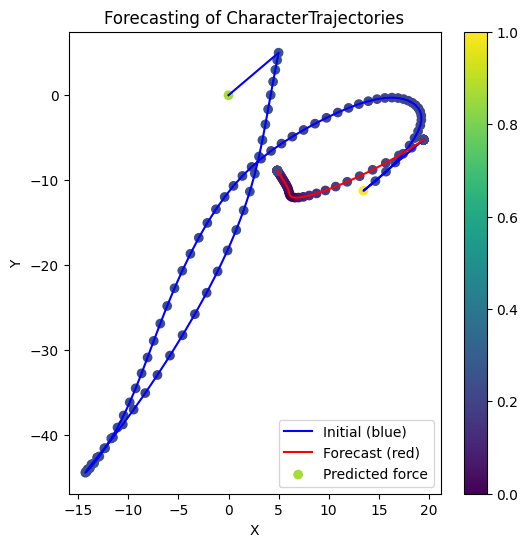

In [51]:
# Define hyperparameters
HP = {
    'log_dir': '/logs',
    'data_path': '../../data/processed/CharacterTrajectories/regression/30',
    'epochs': 500,
    'lr': 1e-4,
    'batch_size': 32,
    'input_channels': 3,
    'hidden_channels': 32,
    'output_channels': 3,
    'n_heads': 4,
    'n_layers': 3,
    'dropout': 0.1
}

X_test = preprocess_for_transformer(X)
X_test = X_test.float()
y_test = y.float()

# Set up test dataloader
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=HP['batch_size'])

# Define model
model = Transformer(HP['input_channels'], HP['hidden_channels'], HP['output_channels'], HP['n_heads'], HP['n_layers'], HP['dropout'])

# Load model
model.load_state_dict(torch.load('logs/transformer_model.pth'))

# Print the number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

# Set model to evaluation mode
model.eval()

batch_x, batch_y = next(iter(test_dataloader))
image_x = batch_x
batch_x, _ = strip_time(batch_x)
batch_y, mask = strip_time(batch_y)
# Offset batch_y by one time step
y_input = batch_y[:,:-1,:]
y_target = batch_y[:,1:,:]

# Make masks
src_padding_mask = model.get_padding_mask(batch_x)
tgt_padding_mask = model.get_padding_mask(y_input)
tgt_mask = model.get_causal_mask(y_input.shape[1])

# Get predictions
pred_y = model(src=batch_x, 
                tgt=y_input, 
                tgt_mask=tgt_mask, 
                src_padding_mask=src_padding_mask, 
                tgt_padding_mask=tgt_padding_mask)
pred_y = pred_y.permute(1, 0, 2) * mask[:,1:,:]

plot_trajectory(image_x, pred_y, 25)

## Neural CDE-Transformer Model

The model has 433,187 trainable parameters


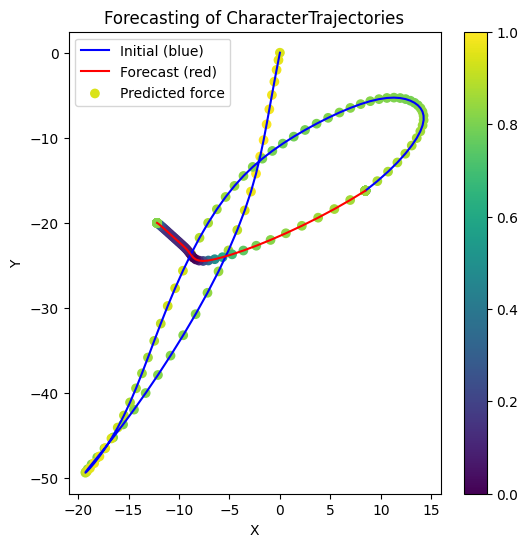

In [ ]:
# Define hyperparameters
HP = {
    'log_dir': '/logs',
    'data_path': '../../data/processed/CharacterTrajectories/regression/30',
    'epochs': 150,
    'lr': 1e-3,
    'batch_size': 32,
    'input_channels': 4,
    'hidden_channels': 32,
    'output_channels': 3,
    'hidden_layers': 3,
    'n_heads': 4,
    'n_layers': 3,
    'dropout': 0.1,
     'method': 'rk4',
    'step_size': 1
}

# Preprocess data
X_test = fill_forward(X)
y_test = y.float()

# Set up test dataloader
test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_test)
test_dataset = torch.utils.data.TensorDataset(X, test_coeffs, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=HP['batch_size'])

# Define model
model = NeuralCDETransformer(HP['input_channels'], HP['hidden_channels'], HP['output_channels'], HP['n_heads'], HP['n_layers'], HP['dropout'])

# Load model
model.load_state_dict(torch.load('logs/ncdetransformer_model.pth'))

# Print the number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

# Set model to evaluation mode
model.eval()

batch_x, coeffs, batch_y = next(iter(test_dataloader))
pred_y = model(coeffs, batch_y)
pred_y = pred_y.squeeze(-1)
pred_y = pred_y.permute(1, 0, 2)

batch_y, mask = strip_time(batch_y)

# Apply mask to pred_y
pred_y = pred_y * mask

plot_trajectory(batch_x, pred_y, 25)

## Neural CDE-ODE

The model has 11,875 trainable parameters


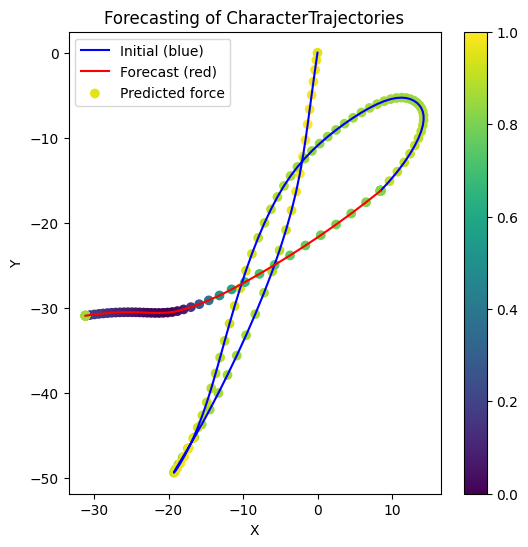

In [ ]:
# Define hyperparameters
HP = {
    'log_dir': '/logs',
    'data_path': '../../data/processed/CharacterTrajectories/regression/30',
    'epochs': 150,
    'lr': 1e-3,
    'batch_size': 32,
    'input_channels': 4,
    'hidden_channels': 32,
    'output_channels': 3,
    'hidden_layers': 3,
    'method': 'rk4',
    'step_size': 1
}

# Preprocess data
X_test = fill_forward(X)
y_test = y.float()

# Set up test dataloader
test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_test)
test_dataset = torch.utils.data.TensorDataset(X, test_coeffs, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=HP['batch_size'])

# Define model
model = NeuralCDEODE(HP['input_channels'], HP['hidden_channels'], HP['output_channels'], missing_data=0.3)

# Load model
model.load_state_dict(torch.load('logs/ncdeode_model.pth'))

# Print the number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

# Set model to evaluation mode
model.eval()

batch_x, coeffs, batch_y = next(iter(test_dataloader))
pred_y = model(coeffs)
pred_y = pred_y.squeeze(-1)

batch_y, mask = strip_time(batch_y)

# Apply mask to pred_y
pred_y = pred_y * mask

plot_trajectory(batch_x, pred_y, 25)

## LSTM Encoder-Decoder Model

In [52]:
# Define hyperparameters
HP = {
    'log_dir': '/logs',
    'data_path': '../../data/processed/CharacterTrajectories/regression/30',
    'epochs': 500,
    'lr': 1e-3,
    'batch_size': 32,
    'input_channels': 4,
    'hidden_channels': 128,
    'output_channels': 3,
    'n_layers': 2
}

# Preprocess data
X_test = preprocess_for_transformer(X)
y_test = y.float()

# Set up test dataloader
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=HP['batch_size'])

# Define model
model = LSTMEncoderDecoder(HP['input_channels'], HP['hidden_channels'], HP['n_layers'], HP['output_channels'])

# Load model
model.load_state_dict(torch.load('logs/lstm_model.pth'))

# Print the number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

# Set model to evaluation mode
model.eval()

batch_x, batch_y = next(iter(test_dataloader))
lengths = getLenghts(batch_x)
pred_y = model(batch_x, lengths)
pred_y = pred_y.squeeze(-1)

batch_y, mask = strip_time(batch_y)

# Apply mask to pred_y
pred_y = pred_y * mask

plot_trajectory(batch_x, pred_y, 25)

The model has 401,283 trainable parameters


RuntimeError: stack expects a non-empty TensorList

## Neural CDE-LSTM

The model has 344,451 trainable parameters


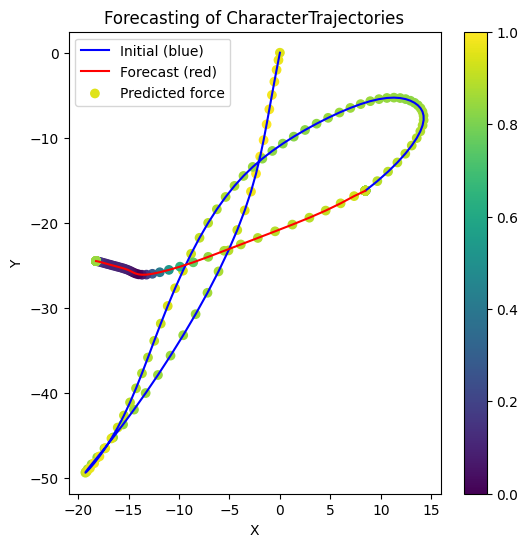

In [53]:
# Define hyperparameters
HP = {
    'log_dir': '/logs',
    'data_path': '../../data/processed/CharacterTrajectories/regression/30',
    'epochs': 150,
    'lr': 1e-3,
    'batch_size': 32,
    'input_channels': 4,
    'hidden_channels': 32,
    'lstm_channels': 128,
    'output_channels': 3,
    'hidden_layers': 3,
    'n_heads': 4,
    'n_layers': 3,
    'dropout': 0.1,
     'method': 'rk4',
    'step_size': 1
}

# Preprocess data
X_test = fill_forward(X)
y_test = y.float()

# Set up test dataloader
test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_test)
test_dataset = torch.utils.data.TensorDataset(X, test_coeffs, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=HP['batch_size'])

# Define model
model = NeuralCDELSTM(HP['input_channels'], HP['hidden_channels'], HP['lstm_channels'], HP['output_channels'], HP['n_layers'])

# Load model
model.load_state_dict(torch.load('logs/ncdelstm_model.pth'))

# Print the number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

# Set model to evaluation mode
model.eval()

batch_x, coeffs, batch_y = next(iter(test_dataloader))
pred_y = model(coeffs)

batch_y, mask = strip_time(batch_y)

# Apply mask to pred_y
pred_y = pred_y * mask

plot_trajectory(batch_x, pred_y, 25)